In [27]:
import math
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [28]:
df = web.DataReader('MSFT', data_source='yahoo', start='2012-01-01', end='2021-05-20')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,26.959999,26.389999,26.549999,26.770000,64731500.0,21.749044
2012-01-04,27.469999,26.780001,26.820000,27.400000,80516100.0,22.260885
2012-01-05,27.730000,27.290001,27.379999,27.680000,56081400.0,22.488358
2012-01-06,28.190001,27.530001,27.530001,28.110001,99455500.0,22.837715
2012-01-09,28.100000,27.719999,28.049999,27.740000,59706800.0,22.537107
...,...,...,...,...,...,...
2021-05-14,249.179993,245.490005,245.580002,248.149994,23901100.0,247.578308
2021-05-17,246.589996,243.520004,246.550003,245.179993,24970200.0,244.615158
2021-05-18,246.410004,242.899994,246.270004,243.080002,20168000.0,242.520004


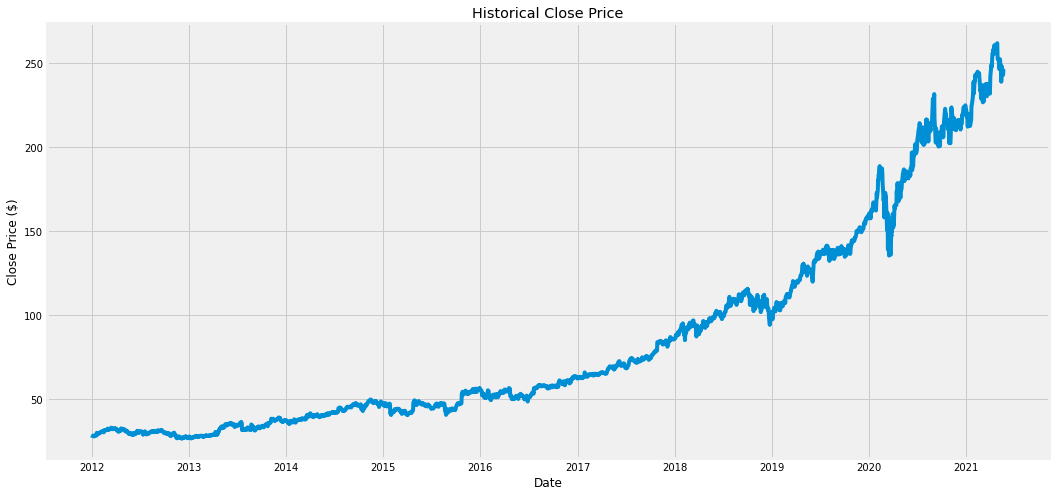

In [29]:
plt.figure(figsize=(16,8))
plt.title('Historical Close Price')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [30]:
data = df.filter(['Close'])
dataset = data.values
train_data_len = math.ceil(len(dataset) * 0.8)

In [31]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00169779],
       [0.00437181],
       [0.00556027],
       ...,
       [0.91982173],
       [0.91999149],
       [0.93425295]])

In [32]:
train_data = scaled_data[0:train_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i])

In [33]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [34]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1829/1829 [==============================] - 61s 28ms/step - loss: 8.3477e-04


In [39]:
test_data = scaled_data[train_data_len - 60: , :]
x_test = []
y_test = dataset[train_data_len: , :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [40]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(472, 60, 1)

In [41]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [43]:
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

3.7726658320022843

In [48]:
train = data[: train_data_len]
valid = data[train_data_len: ]
valid['Predictions'] = predictions

valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,Predictions
Date,,
2019-07-09,136.460007,135.143890
2019-07-10,137.850006,135.349304
2019-07-11,138.399994,135.612473
2019-07-12,138.899994,135.929901
2019-07-15,138.899994,136.292877
...,...,...
2021-05-14,248.149994,240.912521
2021-05-17,245.179993,240.380081
2021-05-18,243.080002,239.945358


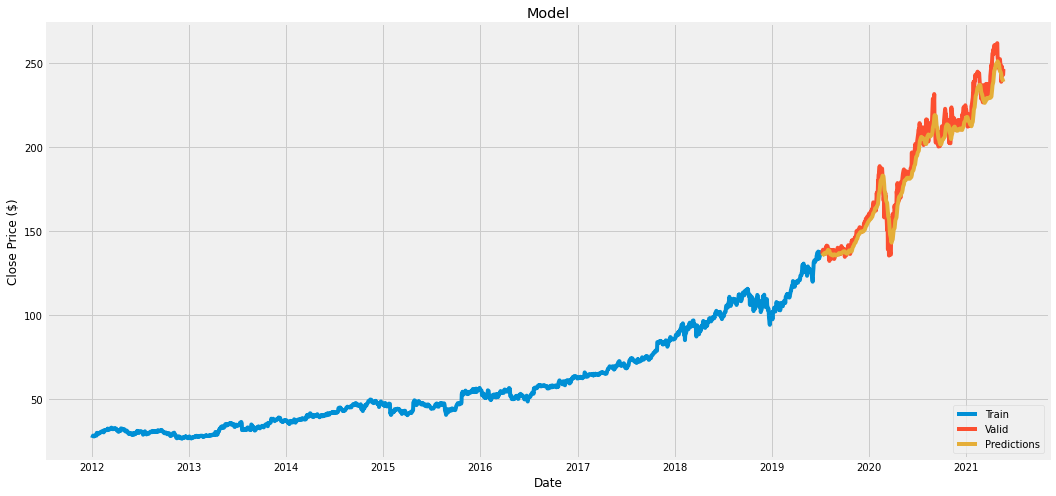

In [49]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

Predict price on 2021-06-01

In [50]:
msft_quote = web.DataReader('MSFT', data_source='yahoo', start='2012-01-01', end='2021-05-31')
new_df = msft_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
new_x_test = []
new_x_test.append(last_60_days_scaled)
new_x_test = np.array(new_x_test)
new_x_test = np.reshape(new_x_test, (new_x_test.shape[0], new_x_test.shape[1], 1))
pred = model.predict(new_x_test)
pred = scaler.inverse_transform(pred)
print(pred)

[[241.67766]]


In [52]:
real_quote = web.DataReader('MSFT', data_source='yahoo', start='2021-06-01', end='2021-06-01')
print(real_quote['Close'])

Date
2021-06-01    247.399994
Name: Close, dtype: float64
